In [14]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
import mpl_toolkits.axes_grid1

from mpl_toolkits import basemap

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Alternative test:  instead of using month-specific percentiles, use percentiles over whole season

In [15]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [16]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]
year_start = 1920
year_end = 2100

In [17]:
year_start_list = numpy.arange(1920,2071)
year_end_list = numpy.arange(1950,2101)

whiplash_ratios_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_pic_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_rcp_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))

# create list of names of members '001','002','003', ...
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'

In [18]:
# create season strings
years_hist_rcp = numpy.arange(1920, 2100+1, 1).astype(numpy.int)

idx_2003 = numpy.where(years_hist_rcp==2003)[0][0]
idx_2033 = numpy.where(years_hist_rcp==2033)[0][0]
idx_2070 = numpy.where(years_hist_rcp==2070)[0][0]
idx_2100 = numpy.where(years_hist_rcp==2100)[0][0]

season_strings_hist_rcp = [str(years_hist_rcp[i])+'-'+str(years_hist_rcp[i+1]) for i in range(years_hist_rcp.size-1)]
#print(season_strings_hist_rcp[idx_2003:idx_2033])

n_seasons_hist_rcp = 2100-1920
#print(len(season_strings_hist_rcp))

In [19]:
# import monthly pic data
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain_MONTHLY_TOTALS/'
monthly_data_pic = numpy.load(working_dir+'member_005_years_0402-2200_threshold_0.1mmday_whole_domain.npy')
#print(monthly_data_pic.shape)
# (26, 25, 1799, 12)

monthly_data_pic_NDJFM = numpy.zeros((26,25,1798,5))

monthly_data_pic_NDJFM[:,:,:,0] = monthly_data_pic[:,:,:1798,10]
monthly_data_pic_NDJFM[:,:,:,1] = monthly_data_pic[:,:,:1798,11]
monthly_data_pic_NDJFM[:,:,:,2] = monthly_data_pic[:,:,1:,0]
monthly_data_pic_NDJFM[:,:,:,3] = monthly_data_pic[:,:,1:,1]
monthly_data_pic_NDJFM[:,:,:,4] = monthly_data_pic[:,:,1:,2]

In [20]:
# import monthly RCP data
monthly_data_hist_rcp = []
for ens_name in ensemble_names:
    monthly_data_hist_rcp.append(numpy.load(working_dir+'PRECT_monthly_data_member_' +ens_name+ '_years_1920-2100_threshold_0.1mmday_whole_domain.npy'))
monthly_data_hist_rcp = numpy.array((monthly_data_hist_rcp))
#print(monthly_data_hist_rcp.shape)
# (40, 26, 25, 181, 12)

# store just NDJFM
monthly_data_hist_rcp_NDJFM = numpy.zeros((40,26,25,180,5))
monthly_data_hist_rcp_NDJFM[:,:,:,:,0] = monthly_data_hist_rcp[:,:,:,:180,10]
monthly_data_hist_rcp_NDJFM[:,:,:,:,1] = monthly_data_hist_rcp[:,:,:,:180,11]
monthly_data_hist_rcp_NDJFM[:,:,:,:,2] = monthly_data_hist_rcp[:,:,:,1:,0]
monthly_data_hist_rcp_NDJFM[:,:,:,:,3] = monthly_data_hist_rcp[:,:,:,1:,1]
monthly_data_hist_rcp_NDJFM[:,:,:,:,4] = monthly_data_hist_rcp[:,:,:,1:,2]

In [21]:
# calculate 80th, 20th percentiles for PIC for each month
#hi_perc = 99
#lo_perc = 1; whiplash_type='9901'

#hi_perc = 90
#lo_perc = 10; whiplash_type='9010'

hi_perc = 80
lo_perc = 20; whiplash_type='8020'

#hi_perc = 66.6
#lo_perc = 33.3; whiplash_type='6633'

#hi_perc = 50
#lo_perc = 50; whiplash_type='5050'

monthly_data_pic_NDJFM_reshape = monthly_data_pic_NDJFM.reshape((26,25,-1))

#pic_hi_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM_reshape, hi_perc, axis=2) # 26x25x5
#pic_lo_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM_reshape, lo_perc, axis=2) # 26x25x5

# ALTERNATIVE VERSION
pic_hi_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM, hi_perc, axis=2) # 26x25x5
pic_lo_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM, lo_perc, axis=2) # 26x25x5

In [22]:
# whiplash events for pic runs
whiplash_lotohi_count_pic = numpy.zeros((1798,26,25))
whiplash_hitolo_count_pic = numpy.zeros((1798,26,25))
for lat_idx in range(26):
    for lon_idx in range(25):
        for s in range(1798):
            for m in range(5-1):
                # lo to hi
                m_val = monthly_data_pic_NDJFM[lat_idx,lon_idx,s,m]
                m_plus_one_val = monthly_data_pic_NDJFM[lat_idx,lon_idx,s,m+1]

                if ( (m_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                    whiplash_lotohi_count_pic[s,lat_idx,lon_idx]+=1
                if ( (m_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                    whiplash_hitolo_count_pic[s,lat_idx,lon_idx]+=1

# Calculate stdev among months for each year

In [23]:
#print(monthly_data_pic_NDJFM.shape)
monthly_data_pic_STDEVS = numpy.std(monthly_data_pic_NDJFM, axis=3)

# Choose PIC lo to hi, hi to lo, or both

In [24]:
#whiplash_pic = whiplash_hitolo_count_pic#+whiplash_lotohi_count_pic
whiplash_pic = whiplash_lotohi_count_pic#+whiplash_hitolo_count_pic
#whiplash_pic = whiplash_hitolo_count_pic+whiplash_lotohi_count_pic

print(whiplash_pic.shape)
whiplash_pic_alltime = numpy.sum(whiplash_pic, axis=0)

(1798, 26, 25)


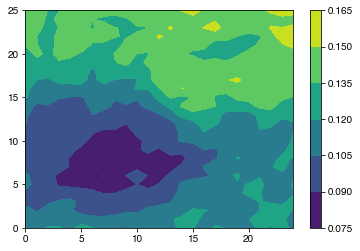

In [25]:
plot_array = whiplash_pic_alltime#+whiplash_hitolo_count_pic
#plot_array = whiplash_hitolo_count_pic
cf=mp.contourf(plot_array/1798)
mp.colorbar(cf)

# Calculate stdevs

In [26]:
print(monthly_data_hist_rcp_NDJFM.shape)
monthly_data_hist_rcp_STDEVS = numpy.std(monthly_data_hist_rcp_NDJFM, axis=4)

#monthly_data_hist_rcp_STDEVS = numpy.std()

(40, 26, 25, 180, 5)


In [27]:
# whiplash events for RCP runs
whiplash_lotohi_count_hist_rcp = numpy.zeros((180,40,26,25))
whiplash_hitolo_count_hist_rcp = numpy.zeros((180,40,26,25))
for ens_idx in range(40):
    print(ens_idx)
    for lat_idx in range(26):
        for lon_idx in range(25):
            for s in range(180):
                for m in range(5-1):
                    # lo to hi
                    m_val = monthly_data_hist_rcp_NDJFM[ens_idx,lat_idx,lon_idx,s,m]
                    m_plus_one_val = monthly_data_hist_rcp_NDJFM[ens_idx,lat_idx,lon_idx,s,m+1]
                    if ( (m_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                        whiplash_lotohi_count_hist_rcp[s,ens_idx,lat_idx,lon_idx]+=1
                    if ( (m_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                        whiplash_hitolo_count_hist_rcp[s,ens_idx,lat_idx,lon_idx]+=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


# Choose HIST+RCP lo-to-hi, hi-to-lo, or both

In [28]:
#whiplash_hist_rcp = whiplash_hitolo_count_hist_rcp# + whiplash_lotohi_count_hist_rcp
whiplash_hist_rcp = whiplash_lotohi_count_hist_rcp# + whiplash_hitolo_count_hist_rcp
#whiplash_hist_rcp = whiplash_lotohi_count_hist_rcp + whiplash_hitolo_count_hist_rcp

print(whiplash_hist_rcp.shape)

whiplash_all_ens_alltime_hist_rcp = numpy.mean(whiplash_hist_rcp, axis=0)
print(whiplash_all_ens_alltime_hist_rcp.shape)
whiplash_all_ens_alltime_hist_rcp = numpy.mean(whiplash_all_ens_alltime_hist_rcp, axis=0)
print(whiplash_all_ens_alltime_hist_rcp.shape)

(180, 40, 26, 25)
(40, 26, 25)
(26, 25)


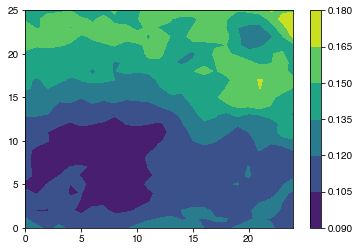

In [29]:
cf=mp.contourf(whiplash_all_ens_alltime_hist_rcp)
mp.colorbar(cf)

# Whiplash for 2003-2033 and 2070-2100

# Calculate whiplash ratios relative to PIC

In [30]:
print(whiplash_hist_rcp.shape)

(180, 40, 26, 25)


In [31]:
whiplash_hist_rcp_alltime = numpy.sum(whiplash_hist_rcp, axis=1)
#print(whiplash_hist_rcp_alltime.shape) # 180x26x25

whiplash_hist_rcp_2003_2033 = numpy.sum(whiplash_hist_rcp_alltime[idx_2003:idx_2033,:,:], axis=0)
whiplash_hist_rcp_2070_2100 = numpy.sum(whiplash_hist_rcp_alltime[idx_2070:idx_2100,:,:], axis=0)

# whiplash events for pic runs
pic_freq = (whiplash_pic_alltime/1798)
# times per century for RCP8.5-like warming
rcp_freq_2003_2033 = (whiplash_hist_rcp_2003_2033/(40*30))
rcp_freq_2070_2100 = (whiplash_hist_rcp_2070_2100/(40*30))

wr_2003_2033 = rcp_freq_2003_2033/pic_freq
wr_2070_2100 = rcp_freq_2070_2100/pic_freq

# Calculate whiplash ratios for only LO to HI events

In [32]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [33]:
# make color map
minval=0.05 # 
maxval=0.95 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

# Plot 2003-2033

# Plot 2070-2100

# Calculate time-latitude array

In [34]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

In [35]:
# pull out cali coast data
wr_2070_2100_cali_coast = wr_2070_2100[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]].reshape((11,3))
print(wr_2070_2100_cali_coast.shape)
whiplash_hist_rcp_2003_2033 = numpy.sum(whiplash_hist_rcp_alltime[idx_2003:idx_2033,:,:], axis=0)

(11, 3)


# Calculate time lat HIST+RCP ratios

In [36]:
# go through 30-year chunks
window=30
time_lat_wr_ratios = numpy.zeros((11,180-window))

pic_freq = whiplash_pic_alltime/1798

print(whiplash_pic_alltime.shape, whiplash_hist_rcp_alltime.shape)
print(whiplash_hist_rcp.shape)

for yr_idx in range(180-window):
    whiplash_window = numpy.sum(whiplash_hist_rcp[yr_idx:(yr_idx+30),:,:,:], axis=0)
    whiplash_window = numpy.sum(whiplash_window, axis=0)
    whiplash_freq = whiplash_window/(40*window)
    whiplash_ratio = whiplash_freq/pic_freq
    time_lat_wr_ratios[:,yr_idx] = numpy.mean(whiplash_ratio[cali_coast_latlon_indices[:,0],\
                                              cali_coast_latlon_indices[:,1]].reshape((11,3)), \
                                              axis=1)


(26, 25) (180, 26, 25)
(180, 40, 26, 25)


# Calculate time-lat PIC ratios

In [37]:
#pic_freq = whiplash_pic_alltime/1798

time_lat_pic_wr_ratios = numpy.zeros((11,1798-window))

for yr_idx in range(1798-window):
    whiplash_window = numpy.sum(whiplash_pic[yr_idx:(yr_idx+window),:,:], axis=0)
    whiplash_freq = whiplash_window/window
    whiplash_ratio = whiplash_freq/pic_freq
    whiplash_ratio_cali_coast = whiplash_ratio[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]].reshape((11,3))
    time_lat_pic_wr_ratios[:,yr_idx] = numpy.mean(whiplash_ratio_cali_coast, axis=1)
for lat_idx in range(11):
    time_lat_pic_wr_ratios[lat_idx,:] = pandas.Series(time_lat_pic_wr_ratios[lat_idx,:]).rolling(window=40, center=True).mean()

print(whiplash_ratio.shape)
print(whiplash_pic.shape)

(26, 25)
(1798, 26, 25)


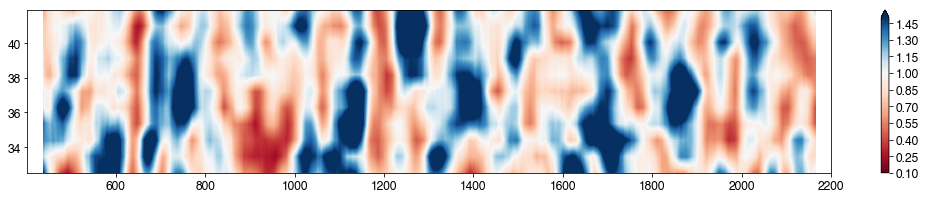

In [38]:
fontsize=12

fig = mp.figure(figsize=(18,3))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=fontsize)

ax.set_xlim(402,2200)

contour_levels = numpy.arange(0.1,1.51,0.01) # lo to hi

cf = ax.contourf(numpy.arange(402+window/2, 2200-window/2), \
                 PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                 time_lat_pic_wr_ratios, \
                 norm=MidpointNormalize(midpoint=1.0), \
                 cmap='RdBu', \
                 extend='max', \
                 levels=contour_levels, \
                 )

cbar = mp.colorbar(cf)
cbar.ax.tick_params(labelsize=fontsize)

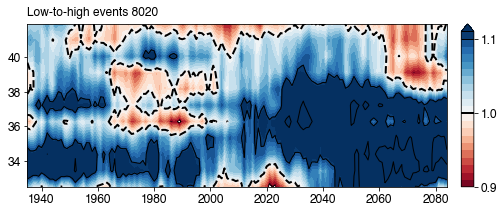

In [39]:
fontsize=12

#cf=mp.contourf(numpy.arange(1935,2085), PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], time_lat_wr_ratios)
fig = mp.figure(figsize=(8,3))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=fontsize)

#contour_levels = numpy.arange(0.7,1.31,0.01) # lo to hi
#contour_levels = numpy.arange(0.4,1.31,0.01) # hi to lo

# ALTERNATIVE
contour_levels = numpy.arange(0.9,1.11,0.01) # lo to hi

cf = ax.contourf(numpy.arange(1920+window/2,2100-window/2), \
                 PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                 time_lat_wr_ratios, \
                 norm=MidpointNormalize(midpoint=1.0), \
                 cmap='RdBu', \
                 extend='max', \
                 levels=contour_levels, \
                 )

contour_plot = ax.contour(numpy.arange(1920+window/2,2100-window/2), \
                 PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                 time_lat_wr_ratios, \
                 levels=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5], \
                 linestyles=['--']*6+['-']*5, \
                 colors=['0']*5+['0']*6, \
                 linewidths=[1]*5+[2]+[1]*5, \
                 )

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = mp.colorbar(cf, cax=cax)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(numpy.arange(contour_levels.min(), contour_levels.max()+0.1,0.1))

#cax.hlines([0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5], 0, 1, \
#                 linestyles=['--']*3+['-']*5, \
#                 colors=['firebrick']*2+['0.25']*6, \
#                 linewidths=[1]*2+[2]+[1]*5, \
#                 )

cbar.add_lines(contour_plot)

#ax.text(s='Low-to-high plus high-to-low events '+whiplash_type, x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
#mp.savefig('lotohi_plus_hitolo_'+whiplash_type+'.pdf', transparent=True, bbox_inches='tight')

#ax.text(s='High-to-low events '+whiplash_type, x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
#mp.savefig('hitolo_'+whiplash_type+'.pdf', transparent=True, bbox_inches='tight')

#ax.text(s='Low-to-high events '+whiplash_type, x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
#mp.savefig('lotohi_'+whiplash_type+'.pdf', transparent=True, bbox_inches='tight')


# ALTERNATE VERSION WHERE MONTHLY DATA ARE TAKEN INTO ACCOUNT
#ax.text(s='Low-to-high plus high-to-low events '+whiplash_type, x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
#mp.savefig('lotohi_plus_hitolo_'+whiplash_type+'_alternate.pdf', transparent=True, bbox_inches='tight')

#ax.text(s='High-to-low events '+whiplash_type, x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
#mp.savefig('hitolo_'+whiplash_type+'_alternate.pdf', transparent=True, bbox_inches='tight')

ax.text(s='Low-to-high events '+whiplash_type, x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
mp.savefig('lotohi_'+whiplash_type+'_alternate.pdf', transparent=True, bbox_inches='tight')






# Time latitude for stdev ratios

In [42]:
print(monthly_data_hist_rcp_STDEVS.shape)
print(monthly_data_pic_STDEVS.shape)

mean_pic_STDEVS = numpy.mean(monthly_data_pic_STDEVS, axis=2)
hist_rcp_STDEVS_ratios = numpy.zeros((26,25,180))
for i in range(180):
    hist_rcp_STDEVS_ratios[:,:,i] = monthly_data_hist_rcp_STDEVS.mean(axis=0)[:,:,i]/mean_pic_STDEVS

stdev_ratios_cali_coast = hist_rcp_STDEVS_ratios[cali_coast_latlon_indices[:,0],\
                                                 cali_coast_latlon_indices[:,1],:].reshape((11,3,-1))
stdev_ratios_cali_coast = numpy.mean(stdev_ratios_cali_coast, axis=1)

window=30

stdev_ratios_cali_coast_running_mean = numpy.zeros((stdev_ratios_cali_coast.shape))
for i in range(11):
    stdev_ratios_cali_coast_running_mean[i,:] = pandas.Series(stdev_ratios_cali_coast[i,:]).rolling(window=window, center=True).mean()







(40, 26, 25, 180)
(26, 25, 1798)


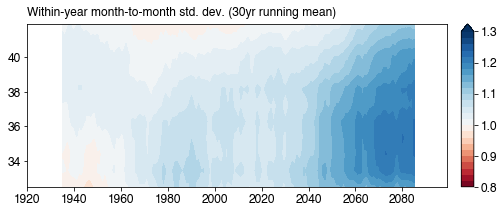

In [43]:
fontsize=12

#cf=mp.contourf(numpy.arange(1935,2085), PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], time_lat_wr_ratios)
fig = mp.figure(figsize=(8,3))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=fontsize)

#contour_levels = numpy.arange(0.7,1.31,0.01) # lo to hi
#contour_levels = numpy.arange(0.4,1.31,0.01) # hi to lo

# ALTERNATIVE
contour_levels = numpy.arange(0.8,1.31,0.02) # lo to hi

cf = ax.contourf(numpy.arange(1920,2100), \
                 PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                 stdev_ratios_cali_coast_running_mean, \
                 norm=MidpointNormalize(midpoint=1.0), \
                 cmap='RdBu', \
                 extend='max', \
                 levels=contour_levels, \
                 )

# contour_plot = ax.contour(numpy.arange(1920+window/2,2100-window/2), \
#                  PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
#                  time_lat_wr_ratios, \
#                  levels=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5], \
#                  linestyles=['--']*6+['-']*5, \
#                  colors=['0']*5+['0']*6, \
#                  linewidths=[1]*5+[2]+[1]*5, \
#                  )

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = mp.colorbar(cf, cax=cax)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(numpy.arange(contour_levels.min(), contour_levels.max()+0.1,0.1))

#cax.hlines([0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5], 0, 1, \
#                 linestyles=['--']*3+['-']*5, \
#                 colors=['firebrick']*2+['0.25']*6, \
#                 linewidths=[1]*2+[2]+[1]*5, \
#                 )

#cbar.add_lines(contour_plot)

ax.text(s='Within-year month-to-month std. dev. ('+str(window)+'yr running mean)', x=0, y=1.03, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize); \
mp.savefig('within_year_stdev_ratios_window_size_'+str(window)+'.pdf', transparent=True, bbox_inches='tight')

# To do:

In [ ]:
#look at 30 yr running window
#ad ksample
#do year-to-year version as well as analogue
#check sensitivity to precip threshold?


# also: plot lens interannual stdev and MMEM interannual stdev; provides comparison of similarity
# to CMIP5 and CESM